# Exoplanets - Coursework Submission: Exercise 2
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

21st June 2024

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the *Exoplanets* module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [Exoplanets - Coursework Assignment](Exoplanets.pdf). The associated report can be found here: [Exoplanets - Coursework Report](report/exo_sd2022_report.pdf).


## Set-Up

### Installations

In [1]:
# Make sure necessary packages are installed

!pip install statsmodels
!pip install numpy
!pip install pandas
!pip install matplotlib
!python -m pip install lightkurve --upgrade
!pip install astropy
!pip install george
!pip install dynesty




### Imports and Settings

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp
import george 
import emcee
from george import kernels, GP
from scipy import optimize
from astropy.timeseries import LombScargle
from utils.plot_tool import plot_time_series_all, plot_periodograms_all, plot_correlations, plot_long_term_trend, plot_stellar_gp_results, plot_gp_predict
from utils.gp_tool import multi_stellar_gp, K_qp, K_qp_multi, gp_predict

# Set up plotting style
plt.style.use('sd2022.mplstyle')
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Gill Sans'
sd2022_blue = '#3772ff'
sd2022_red = '#FF033E'
sd2022_green = '#05a45c'
sd2022_purple = '#994d9e' 
sd2022_orange = '#ff8243'
sd2022_pink = '#df37d6'
sd2022_turq = '#30d5c8'
sd2022_gold = '#cfbd62' 
sd2022_silver = '#C0C0C0'
sd2022_bronze =  '#b08d57'

color_secondary = sd2022_red
color_model = sd2022_green
color_model2 = sd2022_pink


### Load Data

In [3]:
# Load the Doppler radial velocity data
data_path = '../data/ex2_RVs.txt'
df_full = pd.read_csv(data_path, delimiter=',', header=None, names=['time', 'rv', 'rv_err', 'fwhm', 'fwhm_err', 'bispan', 'bispan_err', 'instrument']).drop([0,1,2,3,4,5,6,7]).reset_index(drop=True)
df_full['time'] = df_full['time'].astype(float)
df_full['drv'] = df_full['rv'].diff()
df_full['drv_err'] = np.sqrt(df_full['rv_err']**2 + df_full['rv_err'].shift()**2)
print("Instruments: ", df_full['instrument'].unique())

df = df_full[df_full['instrument'] != 'INST1']
df.head()

Instruments:  ['INST1' 'INST2' 'INST3' 'INST4']


,time,rv,rv_err,fwhm,fwhm_err,bispan,bispan_err,instrument,drv,drv_err
43,5471.805627,0.019196,0.00027,5.4930,0.0006,0.1593,0.0006,INST2,0.03093,0.002495
44,5476.916440,0.020666,0.00019,5.5031,0.0004,0.1564,0.0004,INST2,0.00147,0.000330
45,5479.956295,0.022656,0.00019,5.5066,0.0004,0.1565,0.0004,INST2,0.00199,0.000269
46,5499.951510,0.019916,0.00020,5.5010,0.0004,0.1583,0.0004,INST2,-0.00274,0.000276
47,5777.049420,0.016546,0.00021,5.5223,0.0005,0.1494,0.0005,INST3,-0.00337,0.000290


## Question 1 & 2

Time series for all instruments

Time series
----------------------


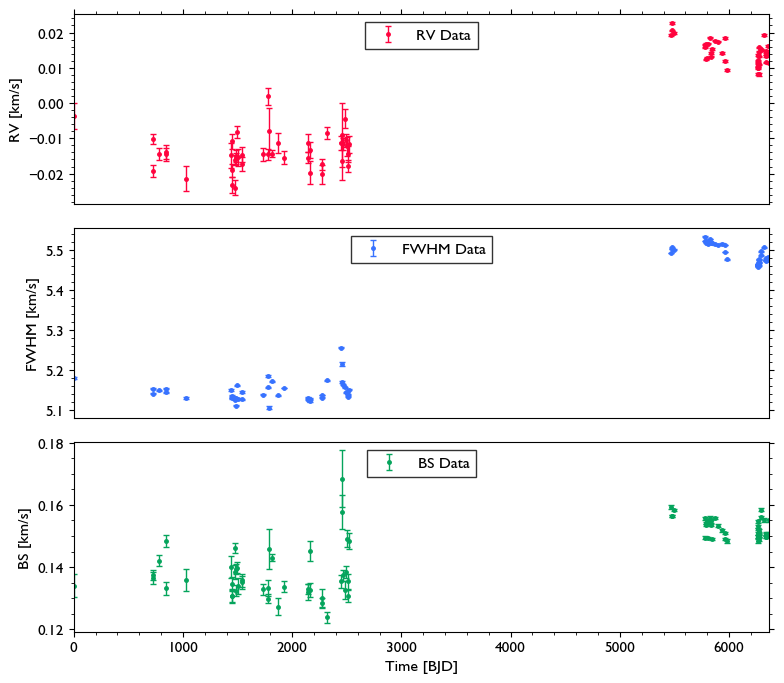

Time series for INST2, INST3, and INST4

Time series
----------------------


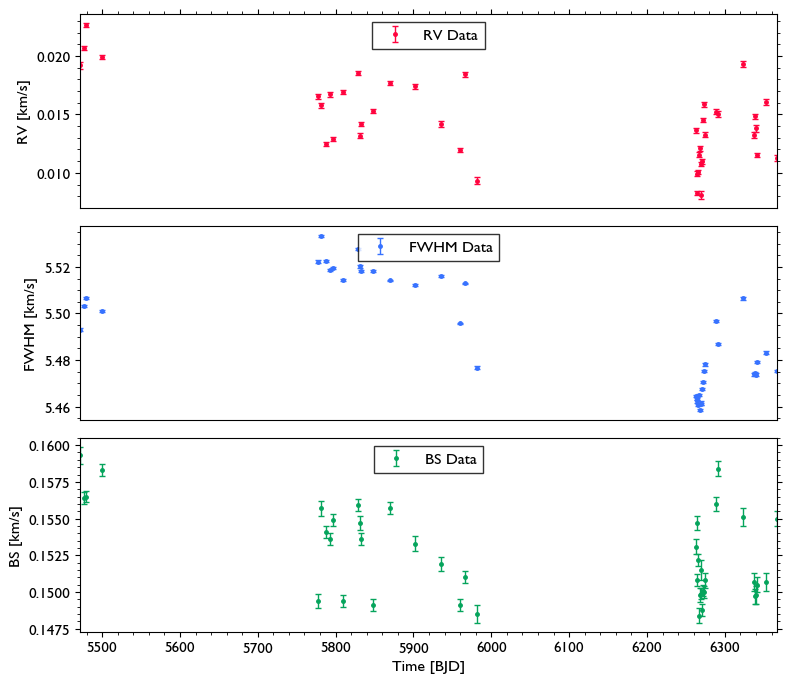

Periodograms for all instruments

Periodograms
----------------------
Periods above FAP =  0.01
RV:  [23.60276155  1.05399657  1.0538856   1.04149482  1.04138647  1.04127814
  1.00008101  0.99988121  0.99908283  0.99888344  0.99768873  0.9975893
  0.9973905   0.97220411  0.51248511  0.51245887  0.51243264  0.51010851
  0.51008252  0.49934453  0.19046868  0.19046506  0.19046143  0.19045781
  0.17994341  0.16007891  0.1599868   0.15998424  0.15998169  0.15992545
  0.15991779  0.15250152  0.15249687  0.15243882  0.13794196  0.13786976
  0.13227482  0.13227307  0.13227132  0.13226957  0.12174233  0.12174085
  0.10852604]
FWHM:  [1.00038085 1.00008101 0.99988121 0.99978135 0.9996815  0.99958167
 0.99948186 0.99938208 0.99788765 0.99778818 0.99768873 0.9975893
 0.99748989 0.9973905  0.99719178 0.99709245 0.99689385 0.49939435
 0.49934453 0.49929471 0.49926981 0.49922001 0.49872256 0.49867287
 0.49859835 0.3327641  0.33274198 0.33273092 0.3327088 ]
BS:  [35.73703001  1.00008101  0.99988121  0

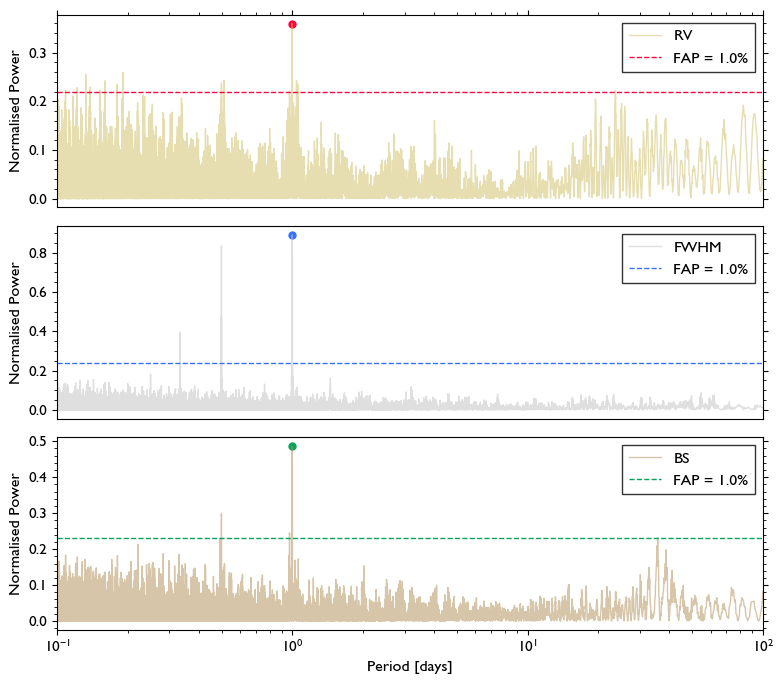


Correlation matrix
----------------------
FWHM Pearson correlation coefficient: 0.9675, p-value: 1.0200e-50
BIS Pearson correlation coefficient: 0.7650, p-value: 2.4503e-17


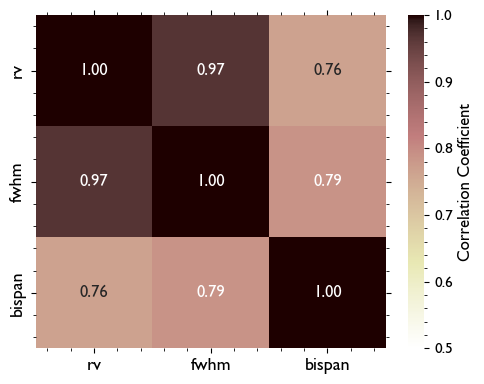

FWHM model summary
----------------------
                            OLS Regression Results                            
Dep. Variable:                     rv   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1199.
Date:                Mon, 24 Jun 2024   Prob (F-statistic):           1.02e-50
Time:                        12:28:35   Log-Likelihood:                 350.32
No. Observations:                  84   AIC:                            -696.6
Df Residuals:                      82   BIC:                            -691.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

/Users/steven/anaconda3/envs/exo/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


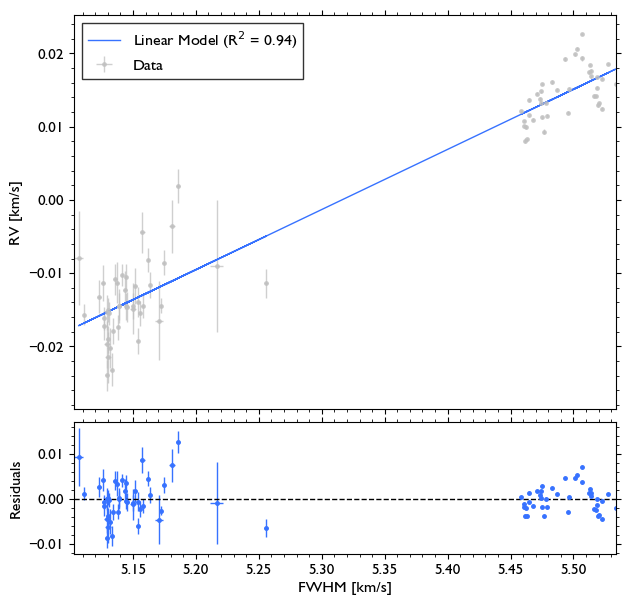

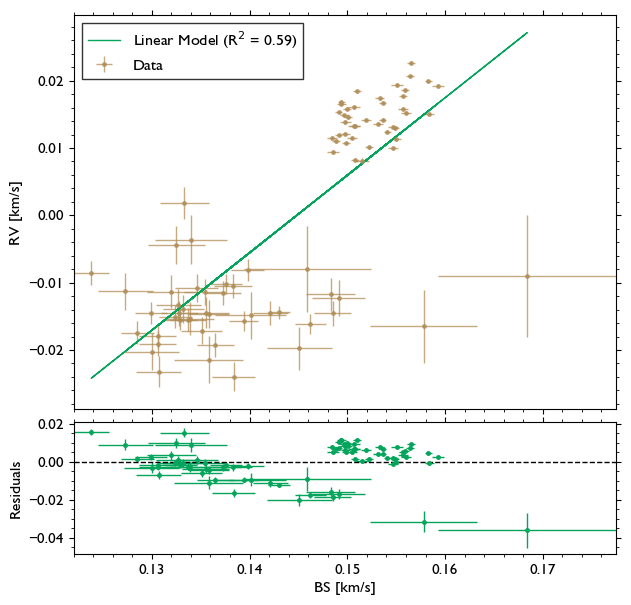


Long-term trends
----------------------


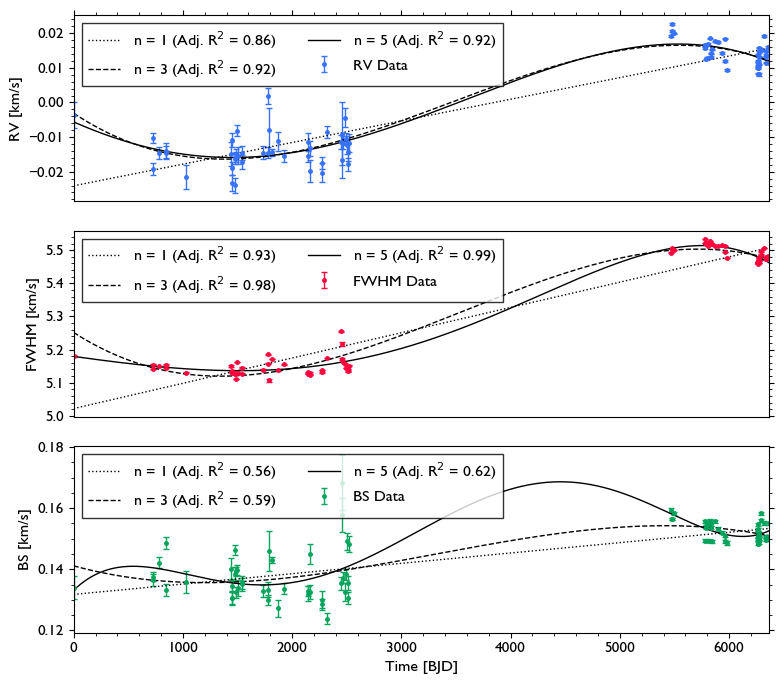

In [4]:
# === Display RV and stellar activity indicator time series ===================

colors = [sd2022_red, sd2022_blue, sd2022_green]
colors2 = [sd2022_gold, sd2022_silver, sd2022_bronze]
# Plot data for all instruments
print("Time series for all instruments")
plot_time_series_all(df_full, cols = colors)

# Plot data for the instrument INST2, INST3, and INST4 only
print("Time series for INST2, INST3, and INST4")
plot_time_series_all(df, cols = colors)

# === Lomb-Scargle periodogram analysis ========================================

# Plot periodograms for all instruments
print("Periodograms for all instruments")
plot_periodograms_all(df_full, cols = colors2, max_p=100, n_p=100000, fap = 0.01, plot_max = True, max_cols = colors)

# # Plot periodograms for the instrument INST2, INST3, and INST4 only
# print("Periodograms for INST2, INST3, and INST4")
# plot_periodograms_all(df, cols = colors, max_p=50, n_p=100000, fap = 0.01)

# === Correlation analysis =====================================================

# Plot correlations for all instruments
res_fwhm, res_bs = plot_correlations(df_full, data_cols=[sd2022_silver, sd2022_bronze], model_cols=[sd2022_blue, sd2022_green])

# # Plot correlations for the instrument INST2, INST3, and INST4 only
# res_fwhm2, res_bs2 = plot_correlations(df, data_cols=[sd2022_silver, sd2022_bronze], model_cols=[sd2022_blue, sd2022_green])

# === Long-term trend analysis =================================================

# Polynomial fit to the RV data
plot_long_term_trend(df_full, degrees = [1, 3, 5], cols = [sd2022_blue, sd2022_red, sd2022_green], fit_cols = ['k', 'k', 'k', 'k', sd2022_purple], ls = [':', '--', '-', ':'])


## Question 3 & 4

In [5]:
# === Stellar Activity Modelling ==============================================

# Data for the GP analysis
factor = 1
df_use = df
time = df_use['time'].values
rv = df_use['rv'].values * factor
rv_err = df_use['rv_err'].values  * factor
fwhm = df_use['fwhm'].values * factor
fwhm_err = df_use['fwhm_err'].values * factor
bispan = df_use['bispan'].values * factor
bispan_err = df_use['bispan_err'].values * factor
y = np.vstack([rv, fwhm, bispan])
yerr = np.vstack([rv_err, fwhm_err, bispan_err])
jitters = np.array([1e-6, 1e-5, 1e-6]) 

# Set prior bounds for the GP analysis
params_shared_bounds = [(21, 41), (0, 20), (250, 2500)] # P, lambda_p, lambda_e
params_individual_bounds = [
    [(0, 1)], # h_rv
    [(0, 10)], # h_fwhm
    [(0, 1)] # h_bispan
]

Running Nested Sampling...


9984it [02:59, 55.59it/s, +500 | bound: 110 | nc: 1 | ncall: 231671 | eff(%):  4.535 | loglstar:   -inf < 449.357 <    inf | logz: 434.015 +/-  0.145 | dlogz:  0.000 >  0.010]


Log-evidence: 434.02 +/- 0.15
Weighted Mean: [3.53201692e+01 6.15718812e+00 1.54744777e+03 1.20158646e-01
 3.92172574e+00 1.64398504e-01]
Weighted Standard Deviation: [6.71087744e-02 2.14745587e+00 3.29753023e+02 8.01380778e-02
 1.43112989e+00 8.65076994e-02]
MAP Estimate: [3.53455603e+01 3.82830149e+00 1.31221476e+03 5.50224083e-02
 2.78353137e+00 8.78936218e-02]
$P_{rot}$ = 35.31867 with 68% credible interval [-0.06333, +0.06854] and 95% credible interval [-0.12345, +0.13845]
$\lambda_p$ = 5.68992 with 68% credible interval [-1.50986, +2.43755] and 95% credible interval [-2.28960, +5.65598]
$\lambda_e$ = 1540.62805 with 68% credible interval [-321.39781, +332.94537] and 95% credible interval [-622.84609, +677.17317]
$h_{RV}$ = 0.09828 with 68% credible interval [-0.04071, +0.08088] and 95% credible interval [-0.06081, +0.24041]
$h_{FWHM}$ = 3.57411 with 68% credible interval [-0.93202, +1.66501] and 95% credible interval [-1.52035, +4.14514]
$h_{BS}$ = 0.14226 with 68% credible inter

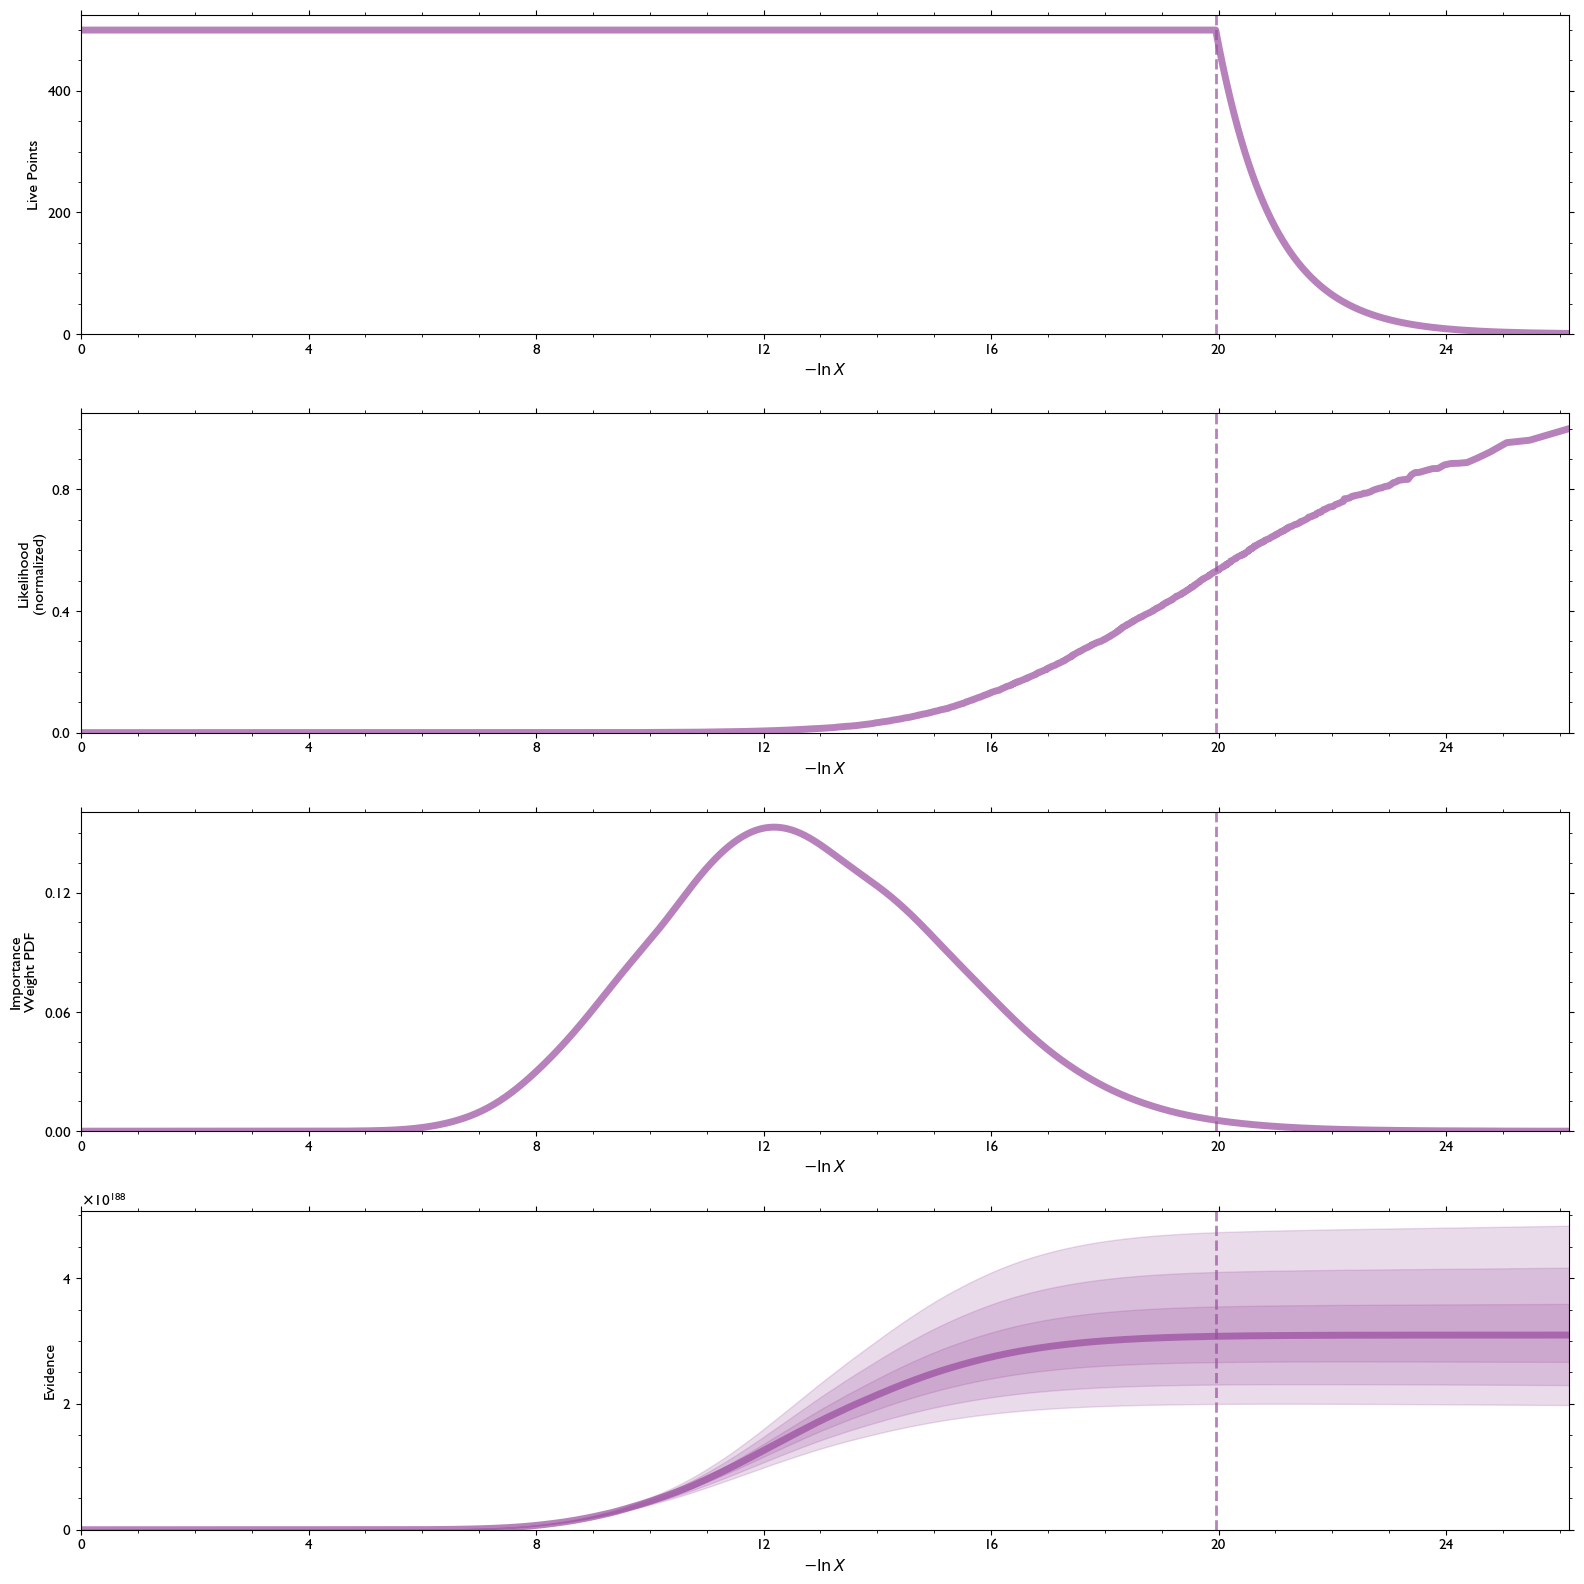

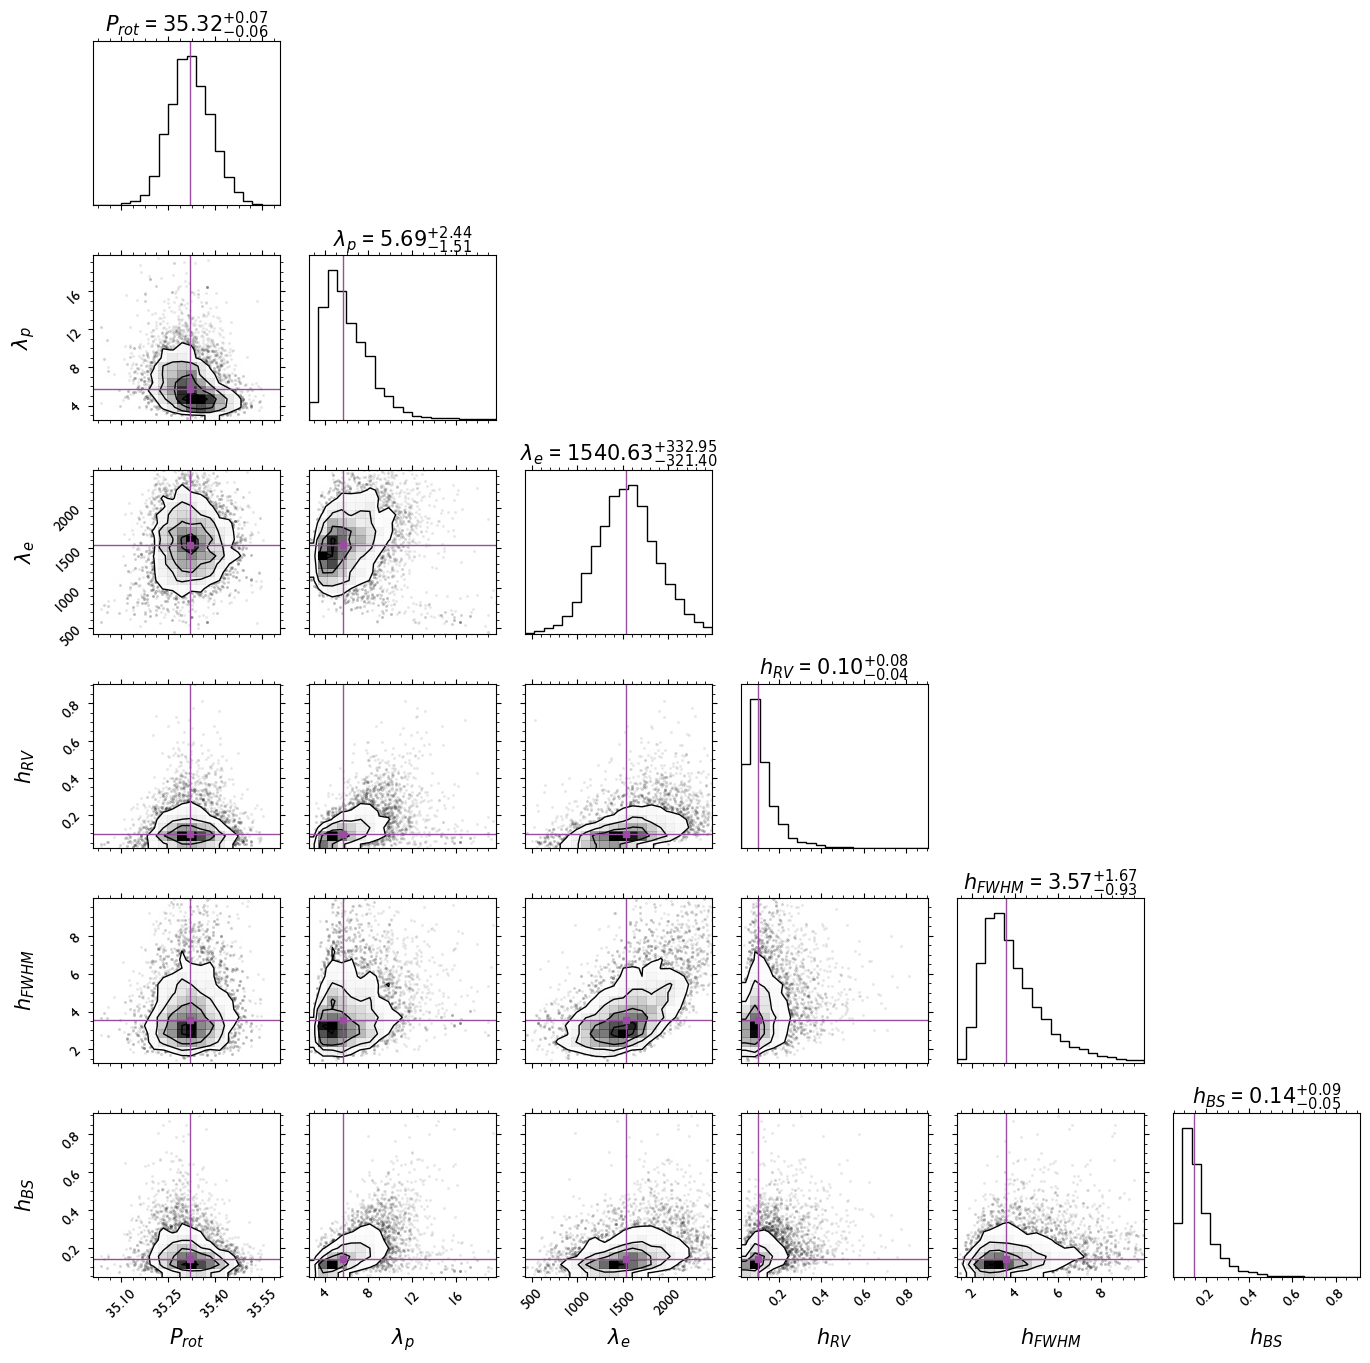

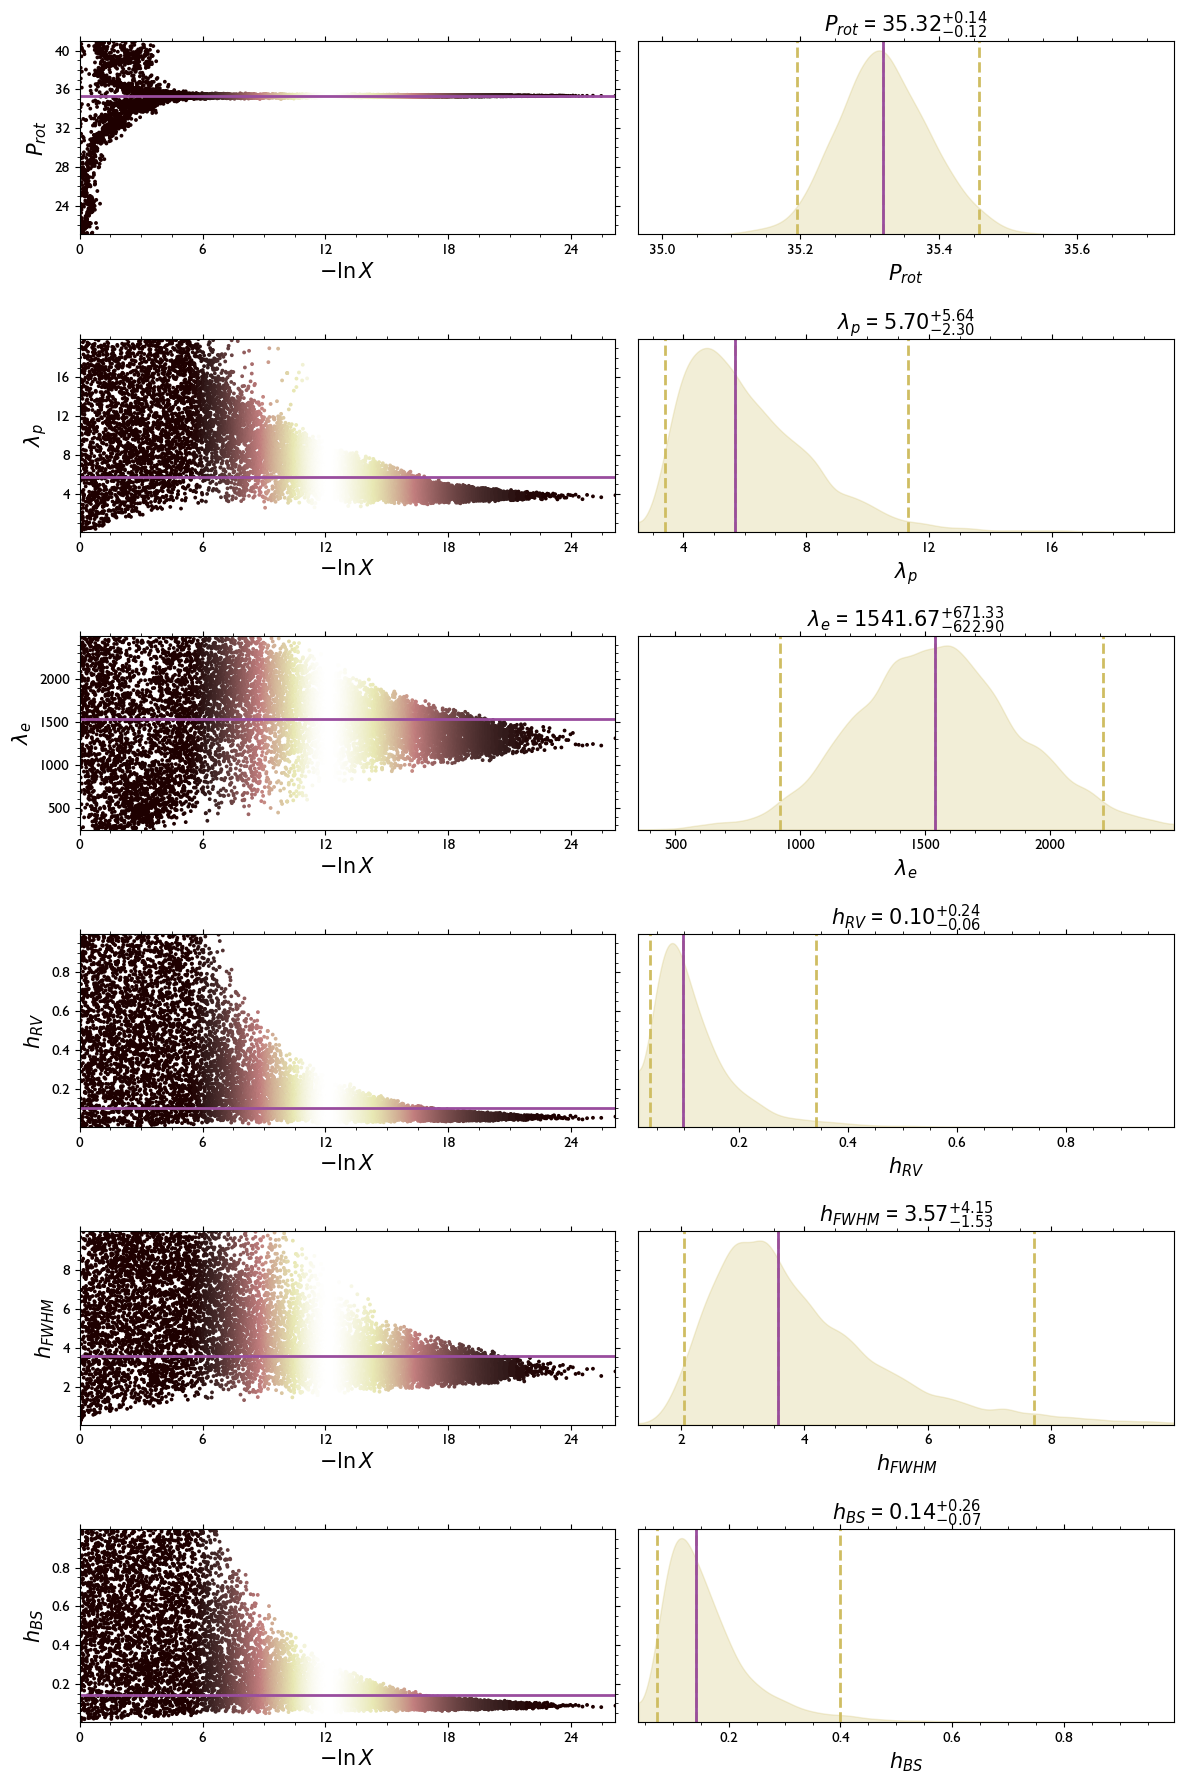

/Users/steven/Desktop/exo/sd2022/src/utils/plot_tool.py:345: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax[i].plot(x_test, mean[i], 'b', lw=2, label='GP Mean', color = colors[i])


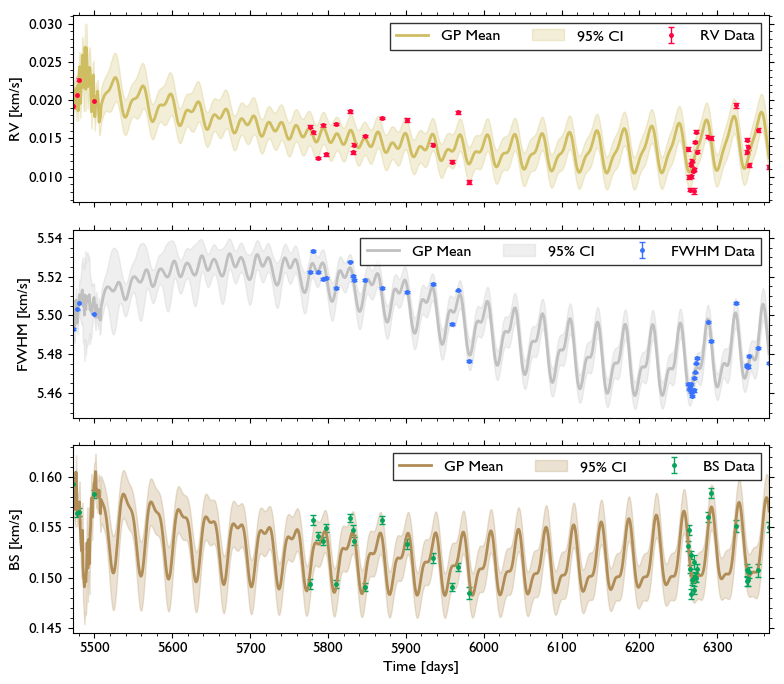

In [6]:
# === 0 Planet Model ==========================================================

# Run nested sampling for the GP analysis
sampler = multi_stellar_gp(time, y, yerr, params_shared_bounds, params_individual_bounds, jitters = jitters)

# Print log evidence
results = sampler.results
logZ = results.logz[-1]         
logZerr = results.logzerr[-1] 
print(f"Log-evidence: {logZ:.2f} +/- {logZerr:.2f}")

# Plot the sampling results
best_fit_parameters = plot_stellar_gp_results(sampler, get_value='median', cmap = 'pink', truth_color=sd2022_purple, corner_color='k', alpha = 0.25, run_color = sd2022_purple, post_color = sd2022_gold)
params_shared = best_fit_parameters[:3]
params_individual = best_fit_parameters[3:]

# Plot the GP prediction
jitters = np.array([1e-6, 1e-5, 1e-6])
time_pred = np.linspace(time.min(), time.max(), 1000)
mean, variance = gp_predict(time, y, time_pred, params_shared, params_individual, jitters =  jitters)
plot_gp_predict(time, y, yerr, time_pred, mean, variance, colors_data = [sd2022_red, sd2022_blue, sd2022_green], colors = [sd2022_gold, sd2022_silver, sd2022_bronze], alpha = 0.25)